In [2]:
import argparse
import cv2
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from keras.callbacks import Callback
from keras.models import model_from_json, Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU,Activation,BatchNormalization
from keras.layers.convolutional import Convolution2D,MaxPooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import scipy
import cv2
import re

np.random.seed(45)

Using TensorFlow backend.


In [3]:
input_shape =(3,160,320)

In [4]:

dirpath = "newdata/"
driveLog_fname = "{}/driving_log.csv".format(dirpath)
image_fdir = dirpath
drivelog = pd.read_csv(driveLog_fname,header=None,names=["center","left","right","steering","throttle","brake","speed"])
images_fname = drivelog.center.values
steering = drivelog.steering.values

images_fname = [re.sub(r"^.*/IMG","IMG",img) for img in images_fname]

print ("Num of Sample in input {}".format(len(images_fname)))



def read_preprocess(fname):
    #preprocessing pipline
    fname = "{}/{}".format(image_fdir,fname)
    img = scipy.misc.imread(fname)
    #img = np.fliplr(img)
    ch,row,col = input_shape
#     img = img[-100:]
#     img = scipy.misc.imresize(img,(row,col))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)    
    img = np.rollaxis(img,2)
    
    return img

#images = np.array([read_preprocess(fname.strip(' \t\n\r')) for fname in images_fname])

train_i,valid_i,train_s,valid_s = train_test_split(images_fname,steering,test_size=0.1, random_state=42)
#train_i,test_i,train_s,test_s = train_test_split(train_i,train_s,test_size=0.10, random_state=42)
print(len(train_i),len(valid_s))
train_sample = len(train_i)
#valid_sample = len(valid_i)
#test_sample = len(test_i)

def getBatch(X,Y,batchSize =40):
    num_sample = len(X)
    start = 0
    end = batchSize
    while True:      
        x = X[start:end]
        y = np.float32(Y[start:end]) 
#         #x = np.array([np.rollaxis(np.float32(scipy.imread("{}/{}".format(image_fdir,x))),2) for x in images])
        x = np.array([read_preprocess(fname.strip(' \t\n\r')) for fname in x])
        augmented = [np.fliplr(img) for img in x]
        x = np.append(x,augmented,axis=0)
        y = np.append(y,-y,axis=0)
        start = start + end
        end = start + batchSize
        if end >= num_sample:
            start = 0
            end = batchSize 
        yield x,y
    return 
test = getBatch(train_i,train_s)


Num of Sample in input 1636
1472 164


In [5]:
def getModel(input_shape):
    ch,col,row =input_shape
    model = Sequential()
#     model.add(Lambda(
#       lambda x: x/255. - 1.0,
#       input_shape=(ch, row, col),
#       output_shape=(ch, row, col))
#   )
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Convolution2D(3, 5, 5,subsample=(2,2), border_mode="same",init="he_normal"))
    model.add(Activation('relu'))
    model.add(Convolution2D(24, 5, 5,subsample=(2,2), border_mode="same",init="he_normal"))
    model.add(Activation('relu'))
    model.add(Convolution2D(36, 5, 5,subsample=(2,2), border_mode="same",init="he_normal"))
    model.add(Activation('relu'))
    model.add(Convolution2D(48, 3, 3,subsample=(1,1), border_mode="same",init="he_normal"))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3,subsample=(1,1), border_mode="same",init="he_normal"))
    model.add(Flatten())
    model.add(Dense(1164,init='uniform'))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(100,init='uniform'))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(50,init='uniform'))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(10,init='uniform'))
    model.add(Activation('relu'))
    model.add(Dense(1))
    optimizer = Adam()
    model.compile(optimizer=optimizer, loss="mse")
    return model

In [6]:
def getModel2(input_shape):
    ch,col,row =input_shape
    model = Sequential()
#     model.add(Lambda(
#       lambda x: x/255. - 1.0,
#       input_shape=(ch, row, col),
#       output_shape=(ch, row, col))
#   )
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Convolution2D(24, 5, 5,subsample=(2,2), border_mode="same",init="he_normal"))
    model.add(Activation('relu'))
    model.add(Convolution2D(36, 5, 5,subsample=(2,2), border_mode="same",init="he_normal"))
    model.add(Activation('relu'))
    model.add(Convolution2D(48, 5, 5,subsample=(2,2), border_mode="same",init="he_normal"))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3,subsample=(1,1), border_mode="same",init="he_normal"))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3,subsample=(1,1), border_mode="same",init="he_normal"))
    model.add(Flatten())
    model.add(Dense(1164,init='uniform'))
    model.add(Dropout(0.8))
    model.add(Activation('relu'))
    model.add(Dense(100,init='uniform'))
    model.add(Dropout(0.8))
    model.add(Activation('relu'))
    model.add(Dense(50,init='uniform'))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(10,init='uniform'))
    model.add(Activation('relu'))
    model.add(Dense(1))
    optimizer = Adam(lr=0.00001)
    model.compile(optimizer=optimizer, loss="mse")
    return model

In [9]:
model = getModel2(input_shape)

In [10]:
model.load_weights("model.h5")

In [11]:
hist = model.fit_generator(getBatch(train_i,train_s),samples_per_epoch = train_sample * 1, nb_epoch=5, verbose=1
                           #,validation_data=getBatch(valid_i,valid_s),nb_val_samples=valid_sample*1
                          )
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)
model.save_weights('model.h5')

Epoch 1/5
1520/1472 [==============================] - 1s - loss: 0.0233     
Epoch 2/5
 320/1472 [=====>........................] - ETA: 0s - loss: 0.0255

/home/gopigrip7/anaconda3/envs/carnd/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


1520/1472 [==============================] - 1s - loss: 0.0220     
Epoch 3/5
1520/1472 [==============================] - 1s - loss: 0.0209     
Epoch 4/5
1520/1472 [==============================] - 1s - loss: 0.0188     
Epoch 5/5
1520/1472 [==============================] - 1s - loss: 0.0178     


In [17]:
model.evaluate_generator(generator=getBatch(test_i,test_s),val_samples=test_sample*1)

NameError: name 'test_i' is not defined

In [45]:

with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

In [46]:
model.save_weights('model.h5')

In [21]:
img = scipy.misc.imread("data/{}".format(train_i[0]))

FileNotFoundError: [Errno 2] No such file or directory: 'data/IMG/center_2016_12_18_14_23_27_503.jpg'

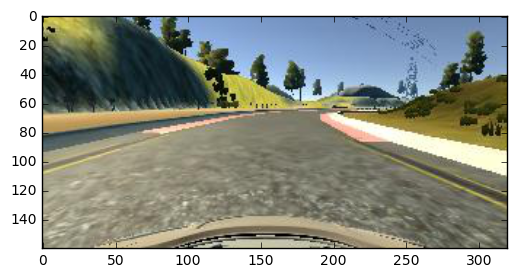

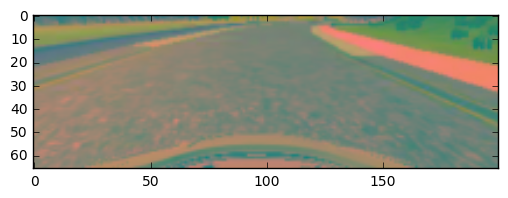

In [308]:
plt.imshow(img)
plt.show()
plt.imshow(cv2.cvtColor(scipy.misc.imresize(img[-100:],(66,200)),cv2.COLOR_RGB2YUV))
plt.show()